In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os

import anndata
import scanpy as sc
%matplotlib inline

plt.style.use('default')
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

## RNA preprocess

In [ ]:
data_list = []
for item in ['exp1','exp2','exp3']:
    data = sc.read_10x_mtx(path + './{}/outs/filtered_feature_bc_matrix/'.format(item))
    data_list.append(data)

adata = AnnData.concatenate(*data_list, 
                            batch_key='exp', 
                            batch_categories=['exp1','exp2','exp3'])

adata.obs_names = [item.replace('-1','') for item in adata.obs_names]

adata.obs['batch'] = adata.obs['exp']
adata.write(path + 'rna_raw.h5ad', compression='gzip')

## CellID preprocess

In [ ]:
## The processed.txt and some intermediate files are too large, we did not upload it, please contact the authors directly if needed.

In [ ]:
for exp in ['exp1','exp2','exp3']:
    in_path = '/home/tiankang/tanglei/submit/processed/Fig.2/{}/'.format(exp)
    data = pd.read_csv(in_path+ 'processed.txt'.format(exp), sep='\t', header=None)  ## processed.txt generated from 01.preprocess.sh
    data.columns = ['Barcode','UMI','CellID']
    data.drop_duplicates(subset=['Barcode','UMI'], inplace=True)
    
    bcs = adata.obs_names
    bcs = np.array([item.split('-')[0] for item in bcs])
    bcs = ref.loc[bcs,'CellID'].values
    
    signal = data[data.Barcode.isin(bcs)]
    noise = data[~data.Barcode.isin(bcs)]
    
    signal_counts = signal.groupby('Barcode')['CellID'].agg(lambda x:x.count()).to_frame()
    noise_counts = noise.groupby('Barcode')['CellID'].agg(lambda x:x.count()).to_frame()
    
    out = pd.DataFrame({'CellID':list(signal_counts['CellID']) + list(noise_counts['CellID']),
                        'Class':["Valid\n droplet"]*len(signal_counts)+['Empty\n droplet']*len(noise_counts)})
    # out.to_csv(in_path + 'nCellID.txt', sep='\t')
    
    sg = pd.DataFrame(signal.groupby('Barcode')['CellID'].value_counts())
    bk = pd.DataFrame(noise.groupby('Barcode')['CellID'].value_counts())
    
    signal_num = sg.groupby('Barcode').apply(lambda x: x.values.squeeze()).to_list()
    cells = sg.index.get_level_values('Barcode')
    cells = list(dict.fromkeys(cells))
    df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in zip(cells, signal_num) ])).T
    df.fillna(0, inplace=True)
    df = df.astype(int)
    df.columns = [str(i+1) for i in range(df.shape[1])]
    df_ratio = df.div(df.sum(axis=1), axis='rows')
    
    noise_num = bk.groupby('Barcode').apply(lambda x: x.values.squeeze()).to_list()
    noise_barcode = bk.index.get_level_values('Barcode')
    noise_barcode = list(dict.fromkeys(noise_barcode))
    df_noise = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in zip(noise_barcode, noise_num) ])).T
    df_noise.fillna(0, inplace=True)
    df_noise = df_noise.astype(int)
    df_noise.columns = [str(i+1) for i in range(df_noise.shape[1])]
    df_noise_ratio = df_noise.div(df_noise.sum(axis=1), axis='rows')
    
    out = pd.DataFrame({'CellID': list(df.iloc[:,:5].values.reshape(-1,))+list(df_noise.iloc[:,:5].values.reshape(-1,)),
                        'Rank':list(df.columns[:5])*df.shape[0]+list(df_noise.columns[:5])*df_noise.shape[0],
                        'Class':['Valid droplet']*(df.shape[0]*5) + ['Empty droplet']*(df_noise.shape[0]*5)})
    
    # df.to_csv(in_path + 'signal_rank.txt', sep='\t')
    # df_noise.to_csv(in_path + 'noise_rank.txt', sep='\t')
    # out.to_csv(in_path + 'CellID_rank.txt', sep='\t')

    df_ratio = df.div(df.sum(axis=1), axis='rows')
    df_noise_ratio = df_noise.div(df_noise.sum(axis=1), axis='rows')
    
    out = pd.DataFrame({'CellID': list(df_ratio.iloc[:,:5].values.reshape(-1,))+list(df_noise_ratio.iloc[:,:5].values.reshape(-1,)),
                        'Rank':list(df_ratio.columns[:5])*df_ratio.shape[0]+list(df_noise_ratio.columns[:5])*df_noise_ratio.shape[0],
                        'Class':['Valid droplet']*(df_ratio.shape[0]*5) + ['Empty droplet']*(df_noise_ratio.shape[0]*5)})
    
    # out.to_csv(in_path + 'CellID_rank_ratio.txt', sep='\t')

    df = pd.read_csv(in_path + 'signal_rank.txt', sep='\t', index_col=0)
    df_noise = pd.read_csv(in_path + 'noise_rank.txt', sep='\t', index_col=0)
    
    tmp1 = df.iloc[:,:2]
    tmp2 = df_noise.iloc[:,:2]
    tmp1['Class'] = 'Valid\ndroplet'
    tmp2['Class'] = 'Empty\ndroplet'
    out = pd.concat([tmp1, tmp2])
    out['CellID'] = out['1']/out['2']
    
    signal_cellid = signal.groupby('Barcode')['CellID'].agg(lambda x:x.value_counts().index[0]).to_frame()
    tmp = signal_cellid.copy()
    df = pd.read_csv(in_path + 'signal_rank.txt', sep='\t', index_col=0)
    df['total'] = df.sum(axis=1)
    tmp['total'] = df.loc[tmp.index,'total']
    tmp.loc[:,'rank1'] = df.loc[tmp.index, '1']
    tmp.loc[:,'rank1_ratio'] = tmp.loc[:,'rank1']/tmp['total']
    tmp.loc[:,'rank2'] = df.loc[tmp.index, '2']
    tmp.loc[:,'rank2_ratio'] = tmp.loc[:,'rank2']/tmp['total']
    # tmp.to_csv(in_path + 'result_without_qc.txt', sep='\t')

## CellID QC

In [2]:
def _plotrank1ratio(df, title=None,save=None):
    tmp = df.copy()
    clump = tmp['CellID'].value_counts().to_frame()
    clump_counts = clump['CellID'].value_counts()

    num = clump_counts.index
    top1_counts, top1_ratio, total_counts, label = [], [], [], []
    for i in num:
        counts = tmp.loc[tmp.CellID.isin(clump[clump['CellID']==i].index),'rank1'].values
        total = tmp.loc[tmp.CellID.isin(clump[clump['CellID']==i].index),'total'].values
        ratio = tmp.loc[tmp.CellID.isin(clump[clump['CellID']==i].index),'rank1_ratio'].values
        total_counts.append(total)
        top1_counts.append(counts)
        top1_ratio.append(ratio)
        label.append([i]*counts.shape[0])

    out = pd.DataFrame({'CellID':np.concatenate(top1_ratio),
                        'Class':np.concatenate(label)})
    plt.figure(figsize=(15,6))
    sns.boxplot(x="Class", y="CellID", data=out, linewidth=1.2, fliersize=0.8, width=0.6,showfliers=False,  saturation=1, palette=['#4692B9'])
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    plt.ylabel('Rank_1 CellID ratio per cell',fontsize=25,labelpad=8)
    plt.xlabel('Clumps',fontsize=25,labelpad=8)
    if title:
        plt.title(title,fontsize=25, pad=8)
    if save:
        plt.savefig(save, bbox_inches='tight')

In [ ]:
adata = sc.read_h5ad('/home/tiankang/tanglei/submit/processed/Fig.2/adata.h5ad') ## rna data after annotation

## Match 10X RNA and CellID barcode, from 10X website
ref = pd.read_csv('/home/tiankang/tanglei/submit/processed/resource/3M-february-2018.txt.gz', header=None,sep='\t', index_col=0)
ref.columns = ['CellID']
ref['RNA'] = ref.index
ref.index = ref['CellID']

rank1_rank2_ratio_threashold = 2
clump_size = 20

In [ ]:
exps = ['exp1','exp2','exp3']
df_all = []
for exp in exps:
    print(exp)
    in_path = '/home/tiankang/tanglei/submit/processed/Fig.2/{}/'.format(exp)
    
    df = pd.read_csv(in_path + 'result_without_qc.txt'.format(exp), sep='\t')
    df.columns = ['CellID_Barcode'] + list(df.columns[1:])

    df['RNA_Barcode'] = ref.loc[df['CellID_Barcode'].values, 'RNA'].values
    df.index = df['RNA_Barcode'].values + '-' + exp
    _plotrank1ratio(df, title=exp, save=fig_path+False)
    
    noise = pd.read_csv(in_path + 'noise_rank.txt', sep='\t', index_col=0)
    noise_ratio = noise.div(noise.sum(axis=1), axis='rows')

    rank1_threashold = np.percentile(noise['rank_1'].values, [25, 50, 75])[2]
    rank1_ratio_threashold = np.percentile(noise_ratio['rank_1'].values, [25, 50, 75])[2]
        
    df['qc'] = '0'
    df.loc[(df['rank1']>rank1_threashold)&
           (df['rank1_ratio']>rank1_ratio_threashold)&
           (df['rank1']/df['rank2']>rank1_rank2_ratio_threashold),'qc']='1'
    
    df = pd.concat([adata[adata.obs['exp']==exp].obs, df], axis=1).reindex(adata[adata.obs['exp']==exp].obs.index)
    df['qc'] = df['qc'].fillna('0')
    _plotrank1ratio(df.loc[df['qc']=='1'], title=exp, save=False)
    
    df_ = df.loc[df['qc']=='1',:]
    clump = df_.loc[:, 'CellID'].value_counts().to_frame()
    idx = clump[clump['CellID']<=clump_size].index
    cells = df_.loc[df_['CellID'].isin(idx)].index
    df['qc'] = '0'
    df.loc[cells, 'qc'] = '1'
    _plotrank1ratio(df.loc[df['qc']=='1'], title=exp, save=False)
    # df.to_csv(in_path + 'result.txt', sep='\t')
    df_all.append(df)
df_all = pd.concat(df_all)
df_all.to_csv('/home/tiankang/tanglei/submit/processed/Fig.2/result.txt', sep='\t')

## pei plot

In [ ]:
def _peiPlot(data, 
             label,
             title='',
             save=None):
    plt.rc('font', family='Helvetica')
    plt.rcParams['pdf.fonttype'] = 42

    # explode = (0.01,0.1)
    explode = tuple([0.02]*data.shape[0])

    # Creating color parameters
    colors = [(1.0, 0.4980392156862745, 0.054901960784313725),
              (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              (1.0, 1.0, 0.6),
              '#f9a500',
              (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
              (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
              (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
              (0.8939638600538254, 0.5441753171856978, 0.7364859669357939),
              '#EDB188',
              '#c8cacc'
             ]

    # Wedge properties
    wp = { 'linewidth' : 0.7, 'edgecolor': "black" ,'width':0.3}

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = pct / 100.*np.sum(allvalues)
        return "{:.1f}%\n({:.0f})".format(pct, absolute)

    # Creating plot
    fig, ax = plt.subplots(figsize =(10, 10))
    wedges, texts, autotexts = ax.pie(data,
                                      radius=0.7, 
                                      autopct = lambda pct: func(pct, data),
                                      explode = explode, 
                                      labels = label,
                                      # shadow = True,
                                      colors = colors,
                                      startangle = 90,
                                      wedgeprops = wp,
                                      textprops = {'fontsize': 20}
                                     )

    ax.legend(wedges, label,
              title ="The number of cells per clump",
              loc="center left",
              bbox_to_anchor=(0.95, 0, 0.5, 1),
              fontsize=18,
              title_fontsize=20,
             )

    plt.setp(autotexts, size = 15, weight ="bold")
    ax.set_title(title, fontsize=20, va='center',pad=1,)
    if save:
        plt.savefig(save, bbox_inches='tight')

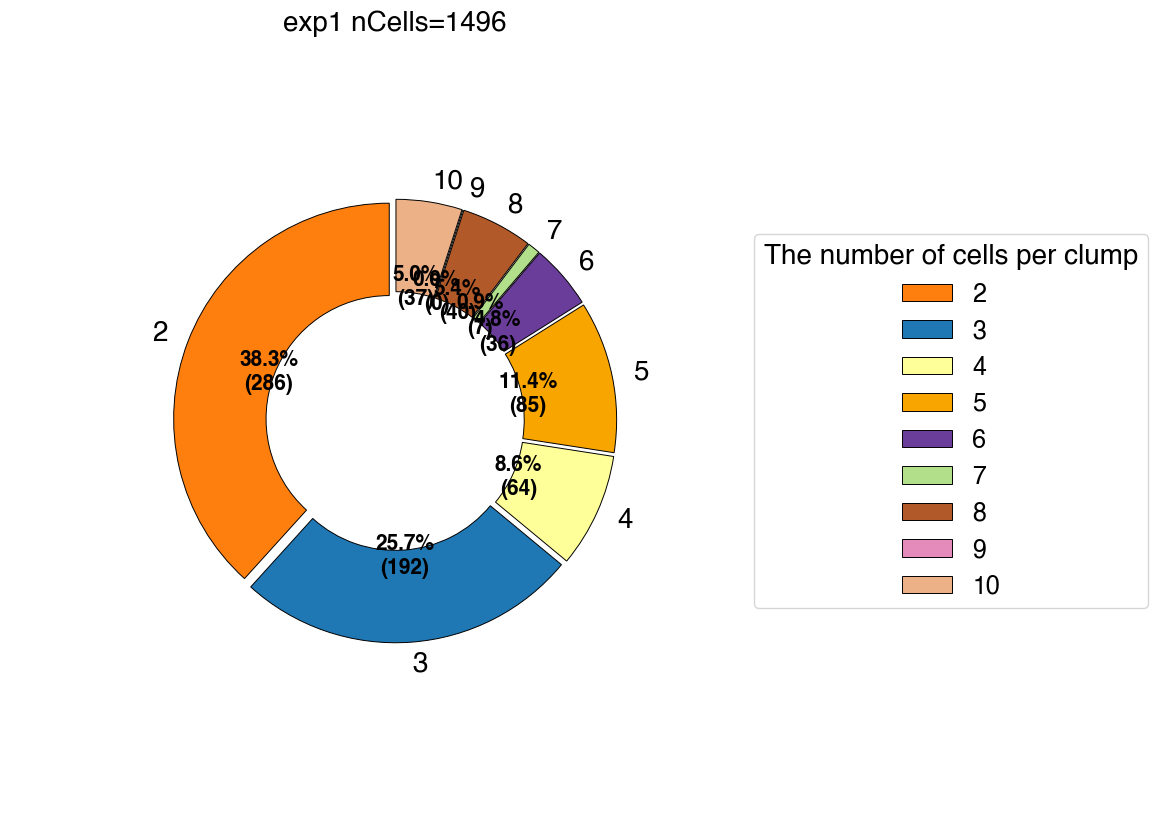

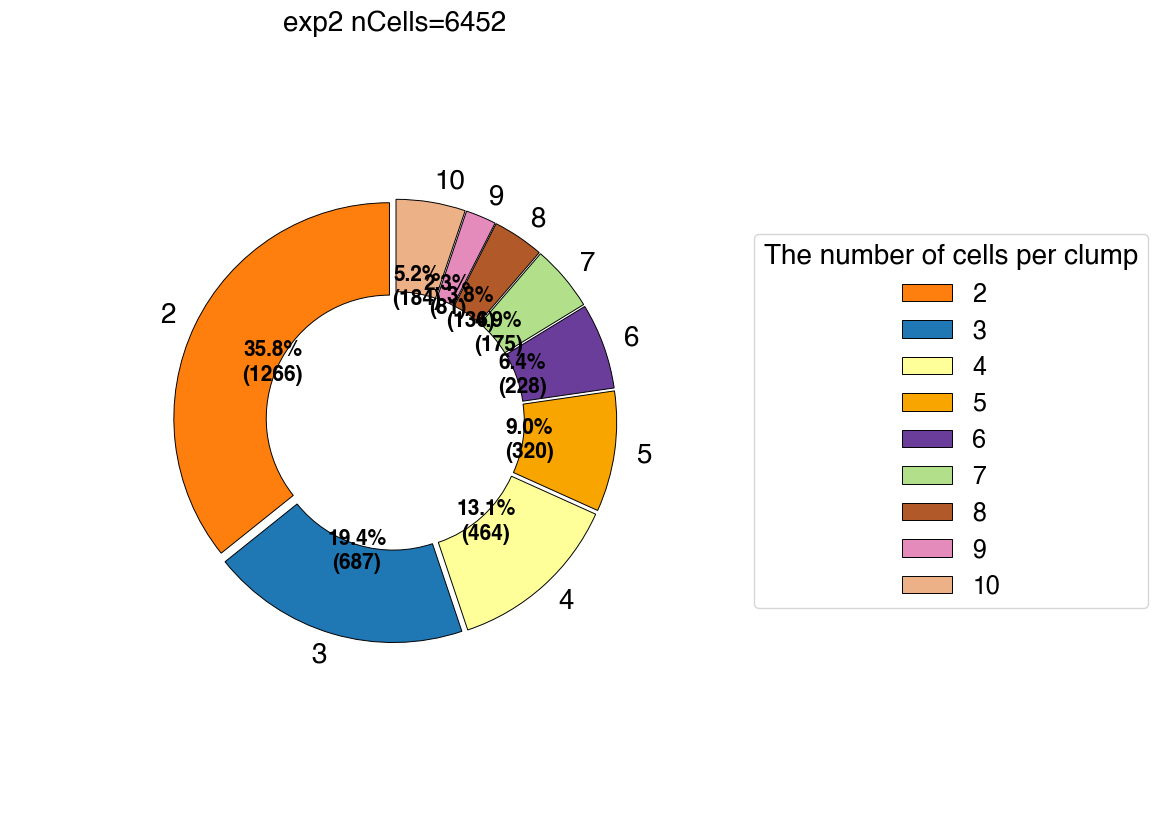

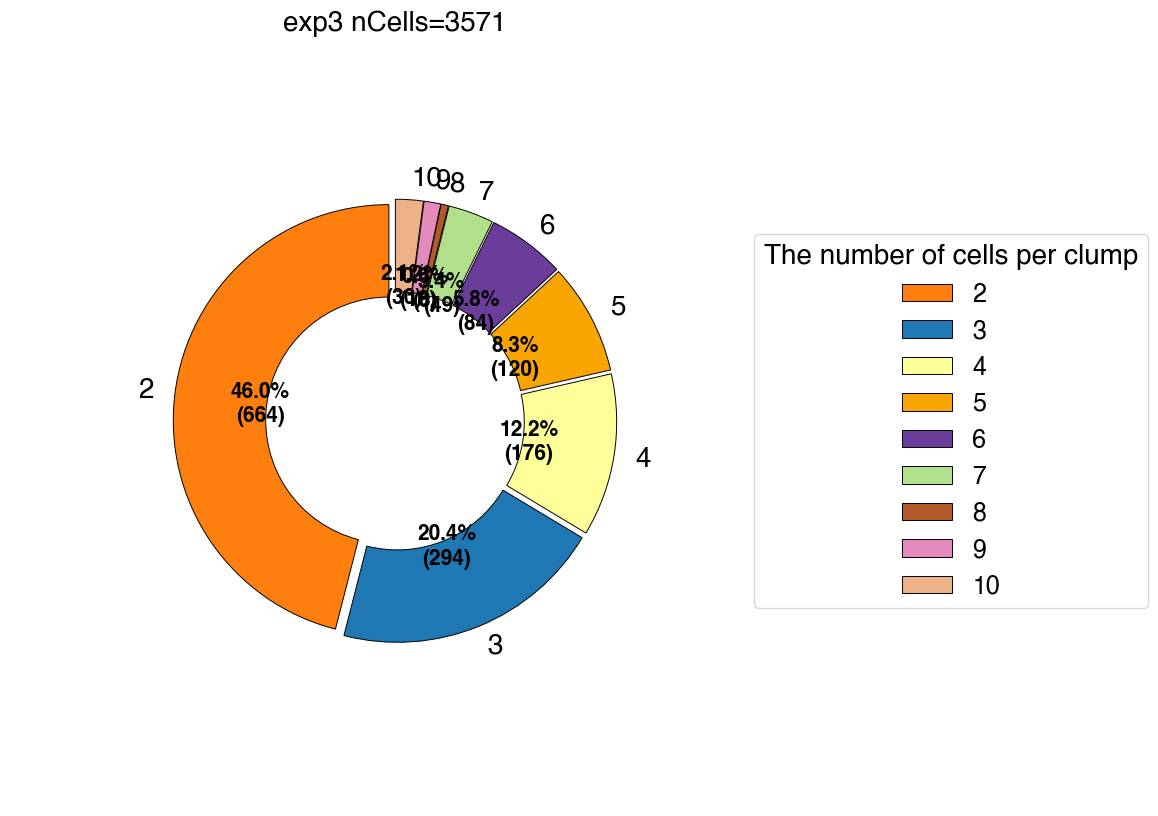

In [33]:
in_path = '/home/tiankang/tanglei/submit/processed/Fig.2/'
df = pd.read_csv(in_path + 'result.txt', sep='\t', index_col=0)
df = df.loc[df['qc']==1]
for c in ['exp1','exp2','exp3']:
    tmp = df.loc[df['exp']==c]
    clump = tmp['CellID'].value_counts().to_frame()
    clump[clump>10] = 10
    clump_counts = clump['CellID'].value_counts()
    clump_counts = clump_counts.reindex([1,2,3,4,5,6,7,8,9,10]).fillna(0).astype(int)
    cell_counts = pd.Series(clump_counts.index * clump_counts.values, index=clump_counts.index)
    cell_counts[10] = tmp.shape[0] - cell_counts.sum()+cell_counts[10]

    plt.style.use('default')
    plt.rc('font', family='Helvetica')
    plt.rcParams['pdf.fonttype'] = 42
    
    _peiPlot(data=cell_counts.values[1:], 
             label=cell_counts.index[1:],
             title='{} nCells={}'.format(c, str(cell_counts.sum())),
             save=False)

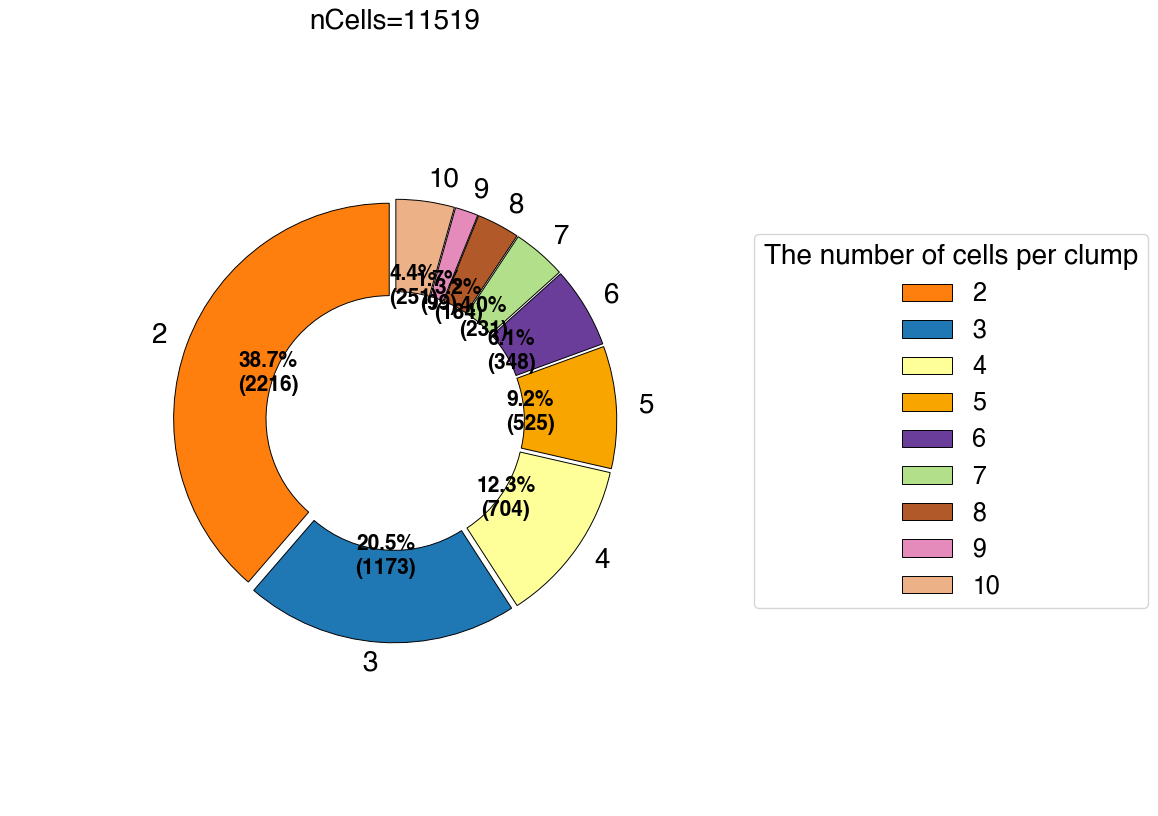

In [39]:
clump = df['CellID'].value_counts().to_frame()
clump[clump>10] = 10
clump_counts = clump['CellID'].value_counts()
clump_counts = clump_counts.reindex([1,2,3,4,5,6,7,8,9,10]).fillna(0).astype(int)
cell_counts = pd.Series(clump_counts.index * clump_counts.values, index=clump_counts.index)
cell_counts[10] = df.shape[0] - cell_counts.sum()+cell_counts[10]

plt.style.use('default')
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

_peiPlot(data=cell_counts.values[1:], 
         label=cell_counts.index[1:],
         title='nCells={}'.format(str(cell_counts.sum())),
         save=False)

## after CellID quality control

In [ ]:
in_path = '/home/tiankang/tanglei/submit/processed/Fig.2/'

df1 = pd.read_csv(in_path + 'exp1/signal_rank.txt', sep='\t', index_col=0)
df_noise1 = pd.read_csv(in_path + 'exp1/noise_rank.txt', sep='\t', index_col=0)
df2 = pd.read_csv(in_path + 'exp2/signal_rank.txt', sep='\t', index_col=0)
df_noise2 = pd.read_csv(in_path + 'exp2/noise_rank.txt', sep='\t', index_col=0)
df3 = pd.read_csv(in_path + 'exp3/signal_rank.txt', sep='\t', index_col=0)
df_noise3 = pd.read_csv(in_path + 'exp3/noise_rank.txt', sep='\t', index_col=0)

df_signal = pd.concat([df1, df2, df3])
df_noise = pd.concat([df_noise1, df_noise2, df_noise3])

In [42]:
data = pd.read_csv('/home/tiankang/tanglei/submit/processed/Fig.2/result.txt', sep='\t', index_col=0)
data = data.loc[data['qc']==1]
df_signal = df_signal.loc[data['CellID_Barcode'].values,:]

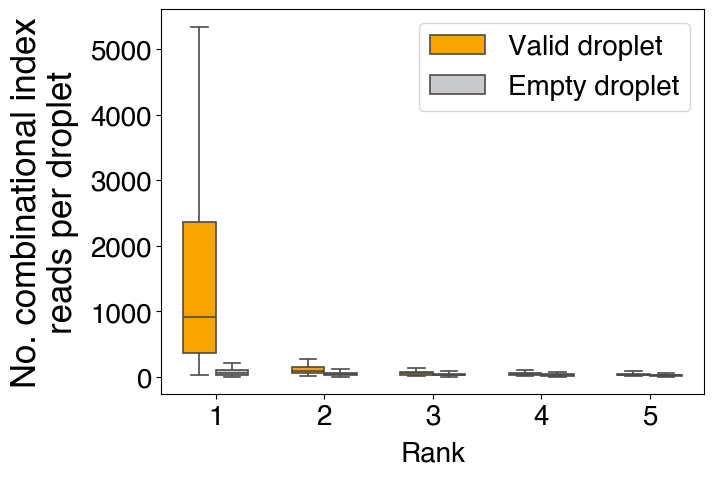

In [43]:
out = pd.DataFrame({'CellID': list(df_signal.iloc[:,:5].values.reshape(-1,))+list(df_noise.iloc[:,:5].values.reshape(-1,)),
                    'Rank':list([1,2,3,4,5])*df_signal.shape[0]+list([1,2,3,4,5])*df_noise.shape[0],
                    'Class':['Valid droplet']*(df_signal.shape[0]*5) + ['Empty droplet']*(df_noise.shape[0]*5)})

plt.figure(figsize=(7,5))
sns.boxplot(x="Rank", 
            y="CellID", 
            data=out, 
            hue='Class', 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.6,
            showfliers=False, 
            saturation=1, 
            palette=['#f9a500', '#c8cacc'])

plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. combinational index\nreads per droplet',fontsize=25,labelpad=8)
plt.xlabel('Rank',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)

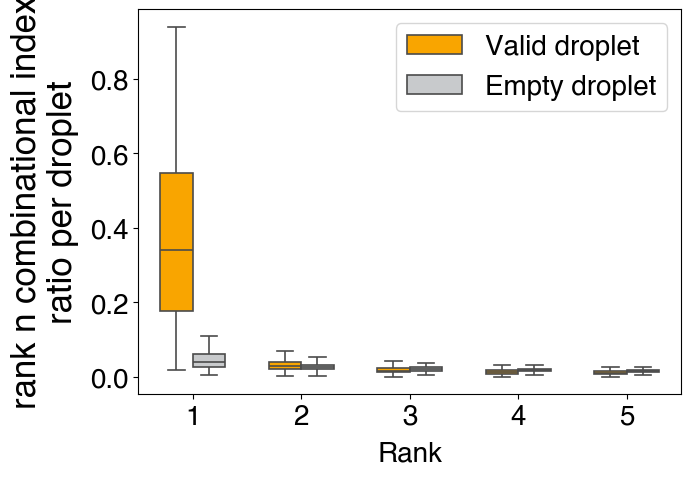

In [44]:
df_signal_ratio = df_signal.div(df_signal.sum(axis=1), axis='rows')
df_noise_ratio = df_noise.div(df_noise.sum(axis=1), axis='rows')

out = pd.DataFrame({'CellID': list(df_signal_ratio.iloc[:,:5].values.reshape(-1,))+list(df_noise_ratio.iloc[:,:5].values.reshape(-1,)),
                    'Rank':list([1,2,3,4,5])*df_signal_ratio.shape[0]+list([1,2,3,4,5])*df_noise_ratio.shape[0],
                    'Class':['Valid droplet']*(df_signal_ratio.shape[0]*5) + ['Empty droplet']*(df_noise_ratio.shape[0]*5)})

plt.figure(figsize=(7,5))
sns.boxplot(x="Rank", 
            y="CellID", 
            data=out, 
            hue='Class', 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.6,
            showfliers=False, 
            saturation=1, 
            palette=['#f9a500', '#c8cacc'])

plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('rank n combinational index\nratio per droplet',fontsize=25,labelpad=8)
plt.xlabel('Rank',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)

In [45]:
d1 = df_signal.sum(axis=1).astype(int)
d2 = df_noise.sum(axis=1).astype(int)
d1 = pd.DataFrame(d1)
d2 = pd.DataFrame(d2)
d1.columns = ['CellID']
d2.columns = ['CellID']
d1['Class'] = 'Valid\ndroplet'
d2['Class'] = 'Empty\ndroplet'

out = pd.concat([d1,d2])

/tmp/ipykernel_1884581/1420286809.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class",


Text(0.5, 1.0, '')

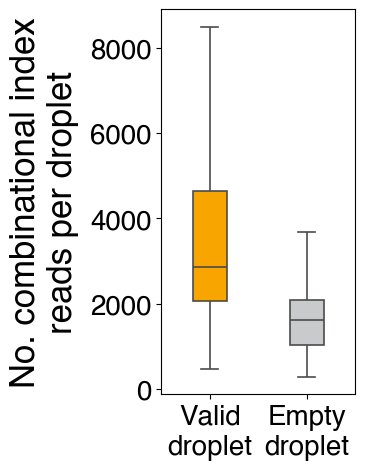

In [46]:
plt.figure(figsize=(2.5,5))
sns.boxplot(x="Class", 
            y="CellID", 
            data=out, 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.35,
            showfliers=False, 
            saturation=1,
            palette=['#f9a500', '#c8cacc'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. combinational index\nreads per droplet',fontsize=25,labelpad=8)
plt.xlabel('',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)

In [47]:
a = out.loc[out.Class=='Valid\ndroplet','CellID'].values
b = out.loc[out.Class!='Valid\ndroplet','CellID'].values

print('Performing t-test analysis...')
from scipy.stats import ttest_ind
from scipy.stats import levene

stat, p = levene(a,b)

if p < 0.05:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=False)
else:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=True)
    
from pprint import pprint
pprint((ttest_ind(a,b, alternative='greater', equal_var=False)[0],
        ttest_ind(a,b, alternative='greater', equal_var=False)[1]))

p = ttest_ind(a,b, alternative='greater', equal_var=False)[1]

Performing t-test analysis...
(52.05231802844787, 0.0)


In [53]:
tmp1 = df_signal.iloc[:,:2]
tmp2 = df_noise.iloc[:,:2]
tmp1['Class'] = 'Valid\ndroplet'
tmp2['Class'] = 'Empty\ndroplet'
out = pd.concat([tmp1, tmp2])
out['CellID'] = out['1']/out['2']

/tmp/ipykernel_1884581/2220622364.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class",


Text(0.5, 1.0, '')

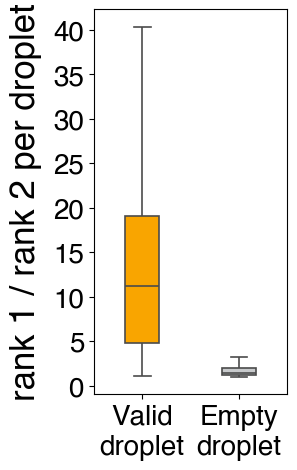

In [52]:
plt.figure(figsize=(2.5,5))
sns.boxplot(x="Class", 
            y="CellID", 
            data=out, 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.35,
            showfliers=False, 
            saturation=1,
            palette=['#f9a500', '#c8cacc'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('rank 1 / rank 2 per droplet',fontsize=25,labelpad=8)
plt.xlabel('',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)

In [54]:
a = out.loc[out.Class=='Valid\ndroplet','CellID'].values
b = out.loc[out.Class!='Valid\ndroplet','CellID'].values

print('Performing t-test analysis...')
from scipy.stats import ttest_ind
from scipy.stats import levene

stat, p = levene(a,b)

if p < 0.05:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=False)
else:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=True)
    
from pprint import pprint
pprint((ttest_ind(a,b, alternative='greater', equal_var=False)[0],
        ttest_ind(a,b, alternative='greater', equal_var=False)[1]))

Performing t-test analysis...
(50.622877285601774, 0.0)
